# Evolution of Two-level Systems under a Field Enhanced by a Spherical Nanoparticle

## Preliminaries

In [1]:
from scipy import special as sp
import numpy as np
import matplotlib.pyplot as plt
import miepython
import pandas as pd
import csv

from ipynb.fs.full.mie_functions_1 import *      #note that mie_functions must be in the same folder

/home/niya/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


### Non-linear Rabi frequency response

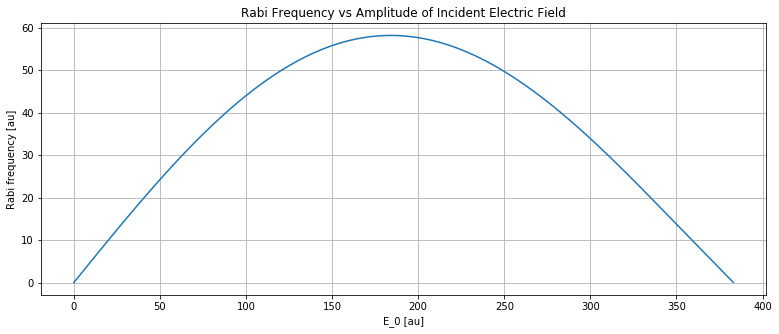

In [2]:
# Rabi Frequency Dependence on Incident Field for a PDM

dx = 1
dy = 0
dz = 0
hbar = 1
E_0 = np.linspace(0,383, 1001)
w = 50
dperm = 0.5

d = np.sqrt(dx**2 + dy**2 + dz**2)

kappa = (E_0 / (hbar * w)) * dperm
Om_R = (d/dperm) * w * sp.jv(1, kappa)


fig, ax = plt.subplots(1,1, figsize = (13, 5))
plt.plot(E_0, Om_R)
plt.xlabel('E_0 [au]')
plt.ylabel('Rabi frequency [au]')
plt.title('Rabi Frequency vs Amplitude of Incident Electric Field')
ax.grid()

# Silver

### Importing data

In [3]:
# Import data for silver (Ag)
# from https://refractiveindex.info/?shelf=main&book=Ag&page=McPeak
ref_lam, ref_n, ref_k = import_data("McPeak_silver.csv")

### Parameters

In [4]:
# Define parameters

a = 0.04                    # radius in microns
m = ref_n - 1.0j * ref_k   # index of refraction
cross_section_area = np.pi * (a ** 2)
mu_a = 4 * np.pi * ref_k / ref_lam    # nm

k = wavenumber(ref_lam, 1) #1 for vacuum   

In [5]:
# Arguments for Bessel and Hankel functions

x = k * a
y = m * k * a

In [6]:
# Find coefficients 

a_1 = a_1_list(m, ref_lam, a)
b_1 = b_1_list(m, ref_lam, a)

### Mie Coefficients: 4 Different Sources

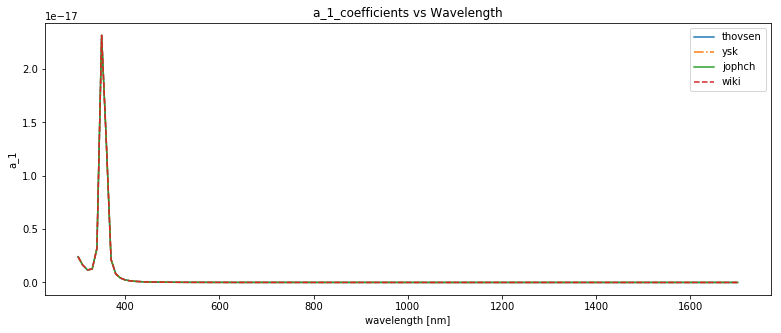

In [7]:
# Check that results from different expressions of Mie coefficients coincide

radius = 100 * (0.1**9) # in m

thovsen = a_1_list(m, ref_lam, radius)
ysk = a_1_list_YSK(m, ref_lam, radius)            # a and b coefficients exchanged in definition
jophch = a_1_list_JoPhCh(m, ref_lam, radius)      # a and b coefficients exchanged in definition
wiki = a_1_list_wiki(m, ref_lam, radius)

fig, ax = plt.subplots(1,1, figsize = (13, 5))
plt.plot(ref_lam*1000, np.real(thovsen), label = 'thovsen')
plt.plot(ref_lam*1000, np.real(ysk), linestyle = '-.', label = 'ysk')
plt.plot(ref_lam*1000, np.real(jophch), linestyle = '-', label = 'jophch')
plt.plot(ref_lam*1000, np.real(wiki), linestyle = '--', label = 'wiki')

plt.xlabel('wavelength [nm]')
plt.ylabel('a_1')
plt.title('a_1_coefficients vs Wavelength')
plt.legend()

## TLS Evolution (with and without PDM)

In [8]:
x_points = np.linspace(a*1000, 2*a*1000, 90)# in nm
#print(x_points)
y_points = np.array([0]) #(-80, 81, 1)   # in nm
z = 0 # in nm

### Spontaneous Emission Factor

In [9]:
# Plot total and radiative gamma factors for different distances away from nanosphere 

def plot_g(d, r = 0.01 * 0.000001, wavelength = 0.4133 * 0.000001, l = np.sqrt(-4.42 + 1j * 0.73),
           JoPhCh = False, YSK = True, plot = True):
    '''
    Plotting components of total and radiative spontaneous emission coefficients.
    '''

    k = l * 2 * np.pi / wavelength # wavenumber
    k_1 = 2 * np.pi / wavelength # wavenumber

    gamma_norm = np.array([])
    gamma_norm_rad = np.array([])
    gamma_tang_rad = np.array([])
    gamma_tang = np.array([])

    for i in d:
    
        if JoPhCh:
            rho = k * i
            a_1_max = a_1_list_JoPhCh(l, wavelength, r)
            b_1_max = b_1_list_JoPhCh(l, wavelength, r)
             
            g_norm = 1 +  (9 / (rho**4)) * np.real(b_1_max * c(rho, first_kind = True) * c(rho, first_kind = True))
            g_tang = 1 + (9 / (4 * (rho**2))) * np.real(a_1_max * c(rho, first_kind = True) * c(rho, first_kind = True) + b_1_max * c_prime(rho, first_kind = True) * c_prime(rho, first_kind = True))
            g_norm_rad = 0
            g_tang_rad = 0
            
        if YSK:
            y_1 = k_1 * i
            
            a_1_max = b_1_list_YSK(l, wavelength, r)
            b_1_max = a_1_list_YSK(l, wavelength, r)
            #a_1_max = - 0.0009 - 1j*0.0052
            #b_1_max = 0

            g_norm = 1 + 9 * np.real(a_1_max * ((c(y_1, first_kind = True)/(y_1**2))**2))
            g_tang = 1 + (9/4) * np.real(a_1_max * ((c_prime(y_1, first_kind = True)/y_1)**2) + b_1_max * (c(y_1, first_kind = True)/y_1)**2)
            g_norm_rad = 9 * np.abs((psi(y_1) + a_1_max * c(y_1, first_kind = True))/(y_1**2))**2      
            g_tang_rad = (9/4) * (np.abs((psi(y_1) + b_1_max * c(y_1, first_kind = True))/y_1)**2 + np.abs((psi_prime(y_1) + a_1_max * c_prime(y_1, first_kind = True))/y_1)**2)
        

        gamma_norm = np.append(gamma_norm, g_norm)
        gamma_tang = np.append(gamma_tang, g_tang)
        gamma_norm_rad = np.append(gamma_norm_rad, g_norm_rad)
        gamma_tang_rad = np.append(gamma_tang_rad, g_tang_rad)

    if plot:
        fig, ax = plt.subplots(1,1, figsize = (9, 9))
        plt.plot(d/r, gamma_norm, label = 'normal')
        plt.plot(d/r, gamma_tang, label = 'tangential')
        plt.plot(d/r, gamma_norm_rad, linestyle = '--', label = 'normal')
        plt.plot(d/r, gamma_tang_rad, linestyle = '--', label = 'tangential')

        #ax.set_ylim(0,2)
        #ax.set_xlim(1,9)
        plt.xlabel('d/a')
        plt.ylabel('y / y_0')
        plt.title('Gamma Factor vs Distance from Field Source')
    
        plt.legend()
        ax.grid()

    return gamma_tang

### Electric Field Around Nanosphere

In [10]:
def scattered_field_components1(x_points, y_points, z, refr_ind, lam_list, r, lam_value = None, n = 1,
                                   plot = True, E_0 = None, gamma = False, rad_only = False):
    
    '''
    Plots the cartesian components of the scattered field at input points. [in V/m]
    
    x_points, y_points - arrays of points for which scattering is calculated [nm]
    z - fixed coordinate that defines the plane of cross section [nm]
    
    refr_ind - list of refractive indices 
    lam_list - list of wavelengths corresponding to refr_ind, in [μm]
    r - radius of particle [μm]
    lam_value - specific wavelength of the incident light; must be in the list of wavelengths [μm]
                If lam_value is omitted, the scattering is performed at the frequency of maximum scattering.
    n - index of refraction of surrounding medium; vacuum by default
    E_0 - amplitude of incident field [au/SI input units determine the output units of the field components]
    
    Boolean:
    plot: if True, output includes plots of the three components
    gamma: if True, a list of gamma factors for the corresponding points (x_points,y_points,z) is calculated
    rad_only: if both gamma and rad only are True, the gamma factor will be calculated just based on radiative 
    spontaneous emission
    '''
    
    # Rescale coordinates to meters
    x_points = x_points * 0.000000001
    y_points = y_points * 0.000000001
    z = z * 0.000000001

    if lam_value != None:
        if lam_value not in lam_list:
            print("Refractive index for this wavelength is not known. Please, choose wavelength from the input list.")
        index = np.where(lam_list == lam_value)
        m_value = refr_ind[index]
    else:
        # Find parameters at resonance
        lam_max = max_lam(refr_ind, lam_list, r, n = 1)
        lam_value = lam_max
        index = np.where(lam_list == lam_max)
        m_value = refr_ind[index]
    
    #Rescale input parameters to meters
    lam_list = lam_list * 0.000001
    lam_value = lam_value * 0.000001
    r = r * 0.000001
    
    print(m_value)
    # Build arrays of points and scattered fields
    E_x_values = np.array([])
    E_y_values = np.array([])
    E_z_values = np.array([])
    gamma_values = np.array([])
    
    points_x = []
    points_y = []
    
    for j in y_points:
        for i in x_points:
            if i**2 + j**2 < r**2:
                E_x = [0]
                E_y = [0]
                E_z = [0]
            
            else:
                E_x, E_y, E_z = scattered_field_cartesian(i, j, z, refr_ind, lam_list, r, lam_value, n,
                                                          absolute_value = True)
            
            if gamma:
                gam = plot_g(x_points, r, wavelength = lam_value, l = m_value,
                             JoPhCh = False, YSK = True, plot = False)
            
         #   x = None,y = None,z = None, d = None, r = 0.01 * 0.000001, wavelength = 0.4133 * 0.000001, 
          #       l = np.sqrt(-4.42 + 1j * 0.73), plot = True
            else: 
                gam = [0]
                
            gamma_values = np.append(gamma_values, gam)
                
            points_x.append(1000000000*i) # rescale to nm for plot
            points_y.append(1000000000*j) # rescale to nm for plot
            
            E_x_values = np.append(E_x_values, E_x)
            E_y_values = np.append(E_y_values, E_y)
            E_z_values = np.append(E_z_values, E_z)
            
    if plot:
    
        # Plot    
        fig, ax = plt.subplots(1, 3, figsize = (16,5))    

        ax[0].scatter(points_y, points_x, c=E_x_values, cmap='jet')
        ax[0].set_title('Scattered Field in X Direction')

        ax[1].scatter(points_y, points_x, c=E_y_values, cmap='jet')
        ax[1].set_title('Scattered Field in Y Direction')

        ax[2].scatter(points_y, points_x, c=E_z_values, cmap='jet')
        ax[2].set_title('Scattered Field in Z Direction')

    
        for i in range(3):
            ax[i].set_xlabel('X [nm]')
            ax[i].set_ylabel('Y [nm]')
            ax[i].set_aspect('equal')
        
        fig.suptitle('Components of Scattered Field', y = 1.06, fontsize = 'xx-large', fontweight='bold')
    

        plt.show()
        plt.savefig("field_components_plot.pdf", format="pdf", bbox_inches="tight")

    # Remove normalisation
    if E_0 != None:
        E_x_values = E_x_values * E_0        
        E_y_values = E_y_values * E_0
        E_z_values = E_z_values * E_0

    return E_x_values, E_y_values, E_z_values, gamma_values

### Plotting Dipole or PDM Evolution

In [11]:
def PDM_Evolution(x_points, y_points, z, refr_ind, lam_list, r, lam_value = None, dx = 1, dy = 0, dz = 0,
                  dperm = None, plot = False, field_in_au = True, E_0 = 0.000001,
                  times = np.linspace(0, 10**7, 100001), filename = 'pdm_coords.txt', spontaneous_emission = True, 
                  legend = False, n = 1, cmap = False, xlim = None, ylim = None):

    '''
    Plots the evolution of a series of permanent dipoles positioned around a scattering nanosphere.
    
    x_points, y_points - arrays of points for which scattering is calculated [nm]
    z - fixed coordinate that defines the plane of cross section [nm]
    
    refr_ind - list of refractive indices 
    lam_list - list of wavelengths corresponding to refr_ind, in [μm]
    r - radius of particle [μm]
    lam_value - specific wavelength of the incident light; must be in the list of wavelengths [μm]
                If lam_value is omitted, the scattering is performed at the frequency of maximum scattering.
    n - index of refraction of surrounding medium; vacuum by default
    dx, dy, dz - components of transition dipole moment [au]
    dperm - permanent dipole moment [au]
    w - resonant frequency of the TLS = frequency of the laser (function assumes no detunning) [au]

    E_0 - amplitude of incident electric field [au]
    times - list of time steps for PDM evolution [au]
    
    Boolean:
    plot - if True, a plot of the three components of the scattered field around the input points is produced
    field_in_au - if False, output field is calculated in SI units [V/m]. Note, input E_0 amplitude must still be
    in atomic units.
    spontaneous_emission - if False, gamma factor is set to zero - no spontaneous emission
    legend - if True, plots legend with values of the scattered field for each line / atom
    '''
    gamma_values = True
    
    if field_in_au:
        hbar = 1  # [au]
        
    else: 
        hbar = 1.054571817 * (0.1**34) # [Js]
        E_0 = E_0 / (5.142206747 * (10**11)) # [V/m]
        dx = dx/(8.478 * (0.1**30)) [Cm]
        dy = dy/(8.478 * (0.1**30)) [Cm]
        dz = dz/(8.478 * (0.1**30)) [Cm]       
        times = times / (2.419 * (10**17))
    
    # Transform frequency of light to au
    speed_of_light_au = 299792458 / (2.187691 * (10**6))
    wavelength_in_meters = lam_value * 0.000001
    wavelength_in_au = wavelength_in_meters / (5.291772109 * (0.1**11))
    w = 2 * np.pi * speed_of_light_au / wavelength_in_au
    
        
    E_x, E_y, E_z, gamma = scattered_field_components1(x_points, y_points, z, refr_ind, lam_list, r, lam_value, 
                                                       n, plot, E_0, gamma_values)

    if lam_value == None:
        # Find parameters at resonance
        a_1_max = max_a_1(refr_ind, lam_list, r, n = 1)
        lam_max = max_lam(refr_ind, lam_list, r, n = 1)
    else:
        index = np.where(lam_list == lam_value)
        m_value = refr_ind[index]
        a_1_max = a_1_list(m_value, lam_value, r)
            
        lam_max = lam_value
        
    # Plotting Evolution
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 9)) 
    colors = plt.cm.jet(np.linspace(0,1,len(E_x)))

    for i in range(len(E_x)):
        e_x = E_x[i]
        e_y = E_y[i]
        e_z = E_z[i]
        
        # Assigning gamma factors to each point
        if spontaneous_emission == False:
            gam = 0
        else:
            if e_x == 0:
                gam = 0
            else:
                gam = gamma[i]
        
        #if gam < 0:
         #   gam = 0
        
        # Calculating Rabi frequency for each point based on field strength
        if dperm != None:
            # permanent dipole moment included
            if e_x != 0:
                d = np.sqrt(dx**2 + dy**2 + dz**2) #transition dipole moment
                kappa = (E_0 / (hbar * w)) * dperm
                Om_R = (d/dperm) * w * sp.jv(1, kappa)
            else:
                Om_R = 0

        else:    
            # just transition dipole moment
            Om_R = (e_x * dx + e_y * dy + e_z * dz) / hbar
            if gam == 0:
                Om_R = 0
       
        # Calculating evolution of density matrix elements
        g = np.sqrt(Om_R**2 - (gam**2) / 16)
        
        #print(Om_R,gam,g)

        
        if Om_R != 0:
            k_factor = ((Om_R**2)/2)/(2*((gam**2)/4) + Om_R**2) #prefactor
        else:
            k_factor = 0
        
        rho_ee = k_factor * (1 - (np.cos(g*times) + 3 * gam * np.sin(g*times) / (4 * g)) * np.exp(-(3/4) * gam * times))

        e = np.sqrt(e_x**2 + e_y**2 + e_z**2)
        
        if cmap:
            ax.plot(times, 2*rho_ee - 1, linewidth=2, label = f'Energy = {e}', color = colors[i]) 
        else:
            ax.plot(times, 2*rho_ee - 1, linestyle = '--', linewidth=2, label = f'Energy = {e}') 

    # Plot the evolution of the PDM

    ax.set_xlabel('times') 
    ax.set_ylabel(r'Tr($\rho\cdot\sigma_z$)')  
    plt.title('Evolution of a TLS Under a Field Enhanced by a Nanosphere')
    ax.grid()
    
    if xlim != None:
        ax.set_xlim(xlim)
    if ylim != None:
        ax.set_ylim(ylim)

    if legend:
        plt.legend()
        
    plt.show() 
    
    return True

In [12]:
#gamma_factor(distance = x_points * 0.000000001, radius = 0.04 * 0.000001, wavelength = 0.38 * 0.000001, 
 #                l = 0.05075241-1.85872962j, plot = True)

array([19.26622754, 18.63146111, 18.02611056, 17.44850735, 16.89709173,
       16.37040489, 15.86708164, 15.38584374, 14.92549372, 14.48490915,
       14.06303742, 13.65889083, 13.27154215, 12.90012043, 12.54380715,
       12.20183273, 11.87347318, 11.55804708, 11.25491277, 10.96346571,
       10.68313609, 10.41338652, 10.15371003,  9.90362803,  9.66268858,
        9.4304647 ,  9.20655277,  8.99057112,  8.78215867,  8.58097367,
        8.38669251,  8.19900864,  8.01763155,  7.84228583,  7.67271024,
        7.5086569 ,  7.34989055,  7.19618774,  7.04733625,  6.90313435,
        6.7633903 ,  6.62792171,  6.49655509,  6.36912529,  6.24547509,
        6.12545475,  6.00892159,  5.89573965,  5.78577929,  5.67891685,
        5.57503439,  5.47401933,  5.37576419,  5.28016634,  5.18712774,
        5.09655471,  5.0083577 ,  4.92245108,  4.83875297,  4.75718502,
        4.67767224,  4.60014288,  4.52452821,  4.45076239,  4.37878238,
        4.30852773,  4.23994051,  4.17296518,  4.10754847,  4.04

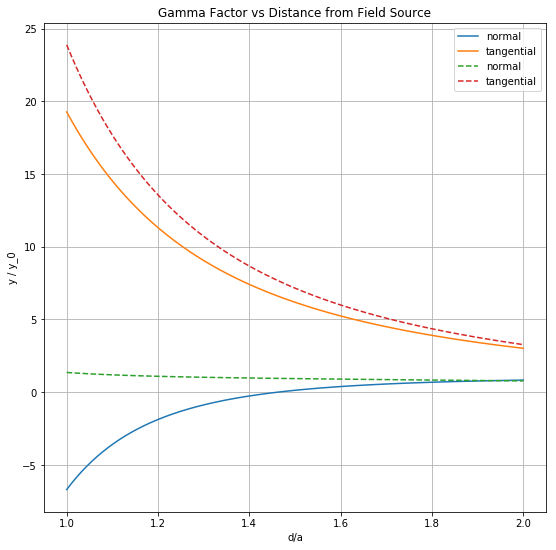

In [13]:
#plot_g(JoPhCh = True, YSK = False)
#plot_g(JoPhCh = False, YSK = True)
#plot_g(x_points * 0.000000001, r = 0.04 * 0.000001, wavelength = 0.54 * 0.000001, l = 0.37250206-2.45166429j,
 #          JoPhCh = False, YSK = True, plot = True)


plot_g(x_points * 0.000000001, r = 0.04 * 0.000001, wavelength = 0.38 * 0.000001, l = 0.05075241-1.85872962j,
           JoPhCh = False, YSK = True, plot = True)

In [14]:
#scattered_field_components1(x_points, y_points, z, m, ref_lam, 0.04, lam_value = 0.38, n = 1,
 #                                   E_0 = 0.000001, gamma = True, rad_only = False)

[0.05075241-1.85872962j]


ipynb.fs.full.mie_functions_1:402: RuntimeWarning: divide by zero encountered in double_scalars


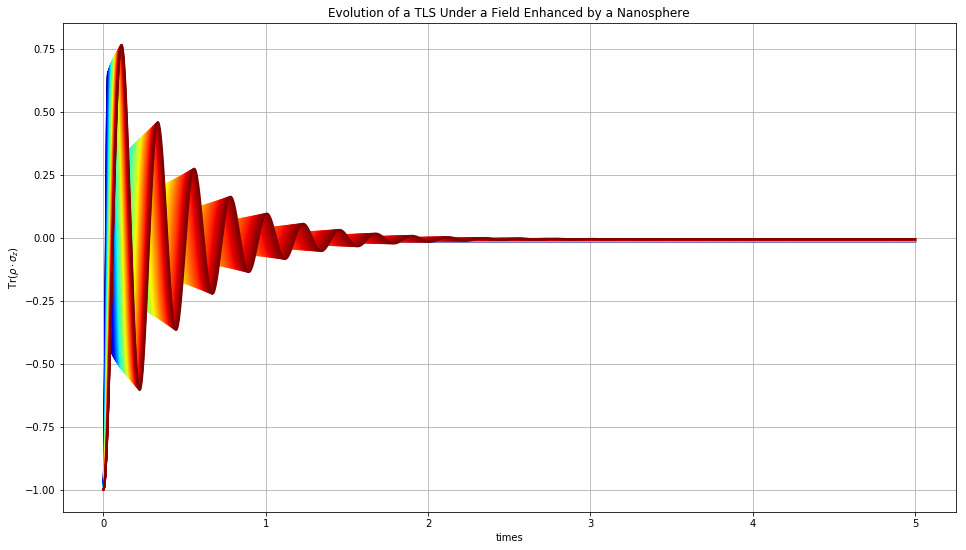

True

In [15]:
# No Spontaneous Emission
PDM_Evolution(x_points, y_points, z, m, ref_lam, a,  dx = 1, dy = 1, dz = 1, lam_value = 0.38, 
              E_0 = 10, times = np.linspace(0, 5, 100001), spontaneous_emission = True, cmap = True)

[0.05075241-1.85872962j]


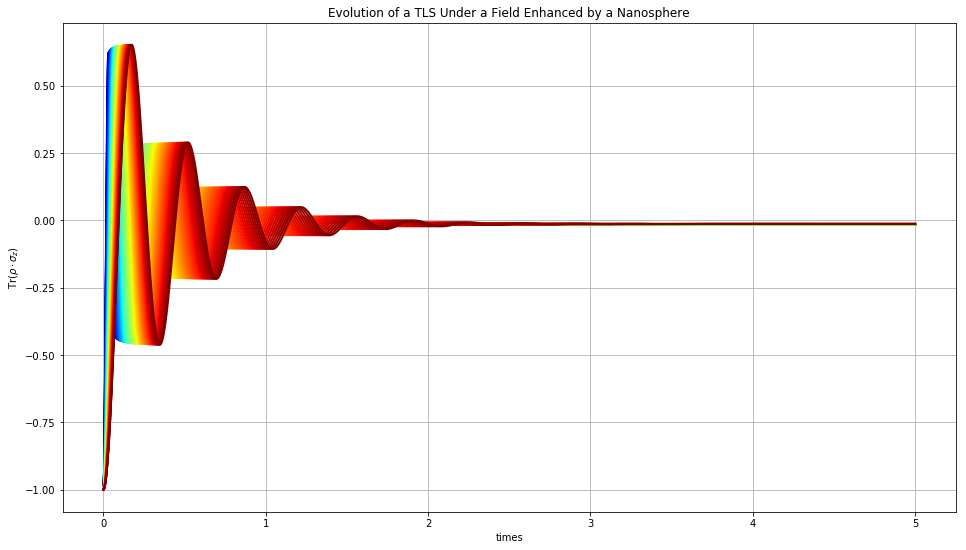

True

In [16]:
# no permanent dipole, spontaneous emission included

PDM_Evolution(x_points, y_points, z, m, ref_lam, a, E_0 = 10, dx = 1, dy = 0, dz = 0, lam_value = 0.38, 
              spontaneous_emission = True, times = np.linspace(0, 5, 100001), cmap = True)

[0.05075241-1.85872962j]


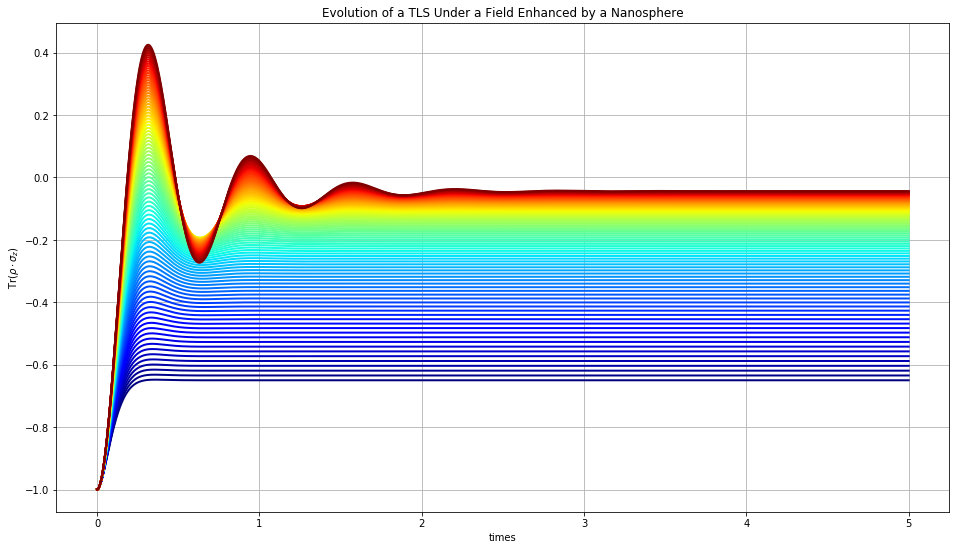

True

In [17]:
# Dipoles oriented along z-axis (parallel to smallest field component)

PDM_Evolution(x_points, y_points, z, m, ref_lam, a, E_0 = 10, dx = 0, dy = 0, dz = 1, lam_value = 0.38, 
              spontaneous_emission = True, times = np.linspace(0, 5, 100001), cmap = True)

[0.05075241-1.85872962j]


/home/niya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt


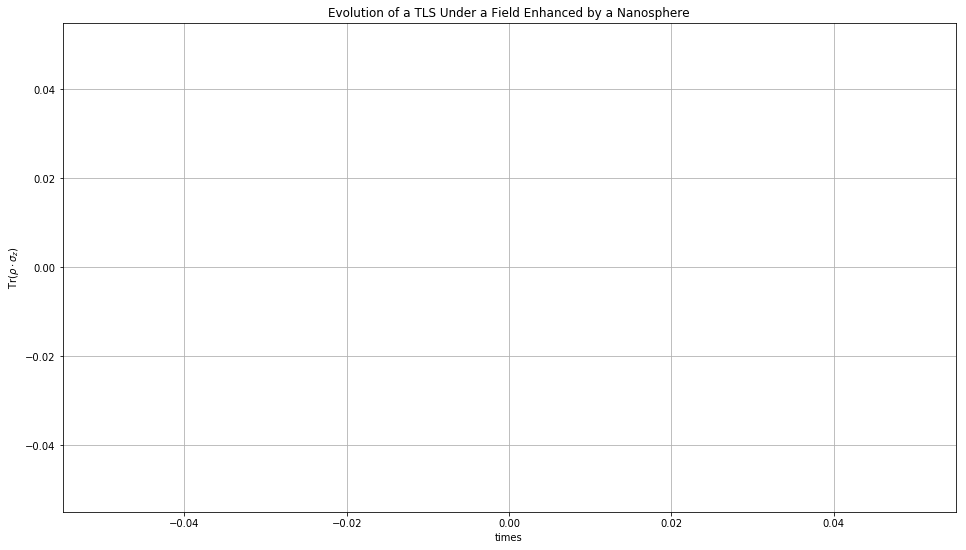

True

In [18]:
# Permanent Dipoles

PDM_Evolution(x_points, y_points, z, m, ref_lam, a, E_0 = 10, dx = 1, dy = 0, dz = 0, dperm = 0.5, 
              lam_value = 0.38, spontaneous_emission = True, times = np.linspace(0, 5, 100001))

# Gold

### Importing data

In [19]:
# Import data for gold (Au)
# from https://refractiveindex.info/?shelf=main&book=Au&page=McPeak
ref_lam, ref_n, ref_k = import_data("McPeak_gold.csv")

### Parameters

In [20]:
# Define parameters

a = 0.04                    # radius in microns
m = ref_n - 1.0j * ref_k   # index of refraction
cross_section_area = np.pi * (a ** 2)
mu_a = 4 * np.pi * ref_k / ref_lam    # nm

k = wavenumber(ref_lam, 1) #1 for vacuum   

In [21]:
# Arguments for Bessel and Hankel functions

x = k * a
y = m * k * a

In [22]:
# Find coefficients 

a_1 = a_1_list(m, ref_lam, a)
b_1 = b_1_list(m, ref_lam, a)

## TLS Evolution (with and without PDMs)

In [23]:
x_points = np.linspace(a*1000, 2*a*1000, 90)# in nm
y_points = np.array([0]) #(-80, 81, 1)   # in nm
z = 0 # in nm

### Plotting PDM evolution

array([-2.75738095, -2.50157575, -2.26474263, -2.04528494, -1.84175603,
       -1.65284369, -1.47735643, -1.31421125, -1.16242272, -1.02109333,
       -0.88940484, -0.76661055, -0.65202844, -0.54503495, -0.44505948,
       -0.35157943, -0.26411573, -0.18222888, -0.10551528, -0.03360407,
        0.03384587,  0.0971485 ,  0.15659304,  0.21244611,  0.26495366,
        0.31434279,  0.3608233 ,  0.40458916,  0.44581982,  0.48468145,
        0.52132798,  0.55590211,  0.58853622,  0.6193532 ,  0.6484672 ,
        0.67598431,  0.70200319,  0.72661565,  0.74990718,  0.77195742,
        0.79284062,  0.81262601,  0.83137823,  0.84915761,  0.86602052,
        0.88201966,  0.89720431,  0.91162058,  0.92531164,  0.93831793,
        0.95067732,  0.96242536,  0.97359537,  0.98421862,  0.99432446,
        1.00394049,  1.01309262,  1.02180522,  1.03010122,  1.03800217,
        1.04552839,  1.052699  ,  1.05953201,  1.06604441,  1.07225222,
        1.07817053,  1.08381362,  1.08919493,  1.09432717,  1.09

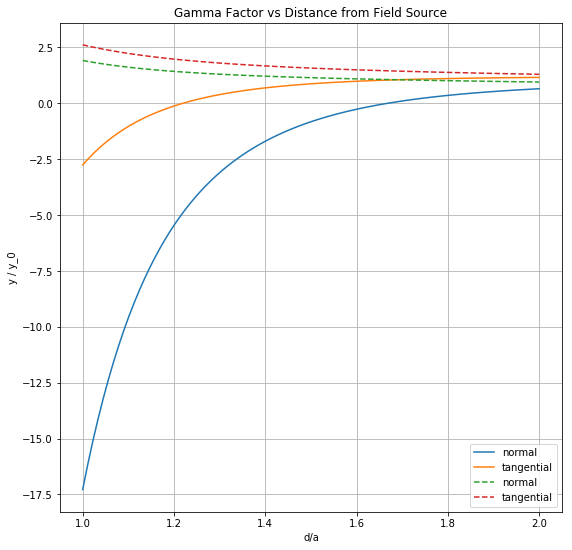

In [24]:
# Gamma factors

plot_g(x_points * 0.000000001, r = 0.04 * 0.000001, wavelength = 0.54 * 0.000001, l = 0.37250206-2.45166429j,
           JoPhCh = False, YSK = True, plot = True)

[0.37250206-2.45166429j]


/home/niya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in true_divide


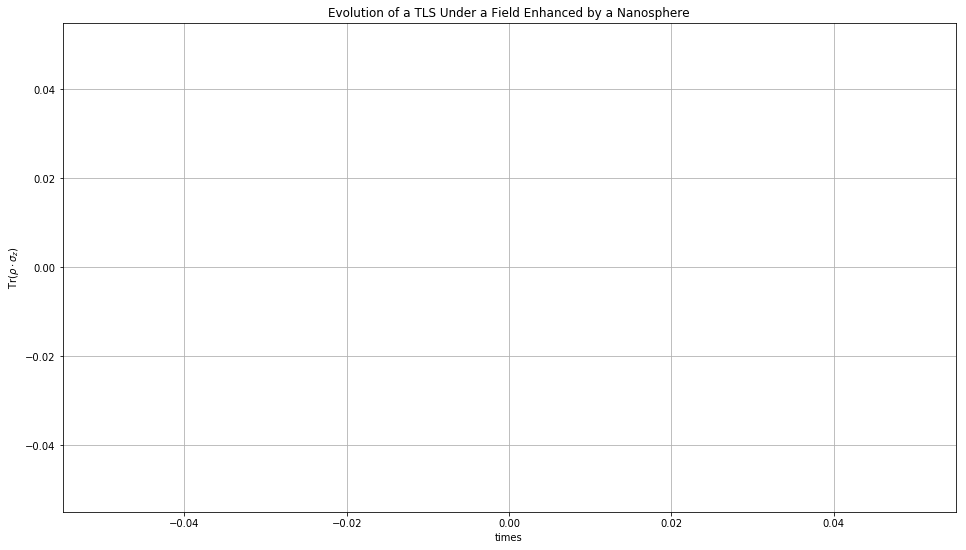

True

In [25]:
# No Spontaneous Emission
PDM_Evolution(x_points, y_points, z, m, ref_lam, a,  dx = 1, dy = 1, dz = 1, lam_value = 0.54, 
              E_0 = 10, times = np.linspace(0, 5, 100001), spontaneous_emission = False, cmap = True)

[0.37250206-2.45166429j]


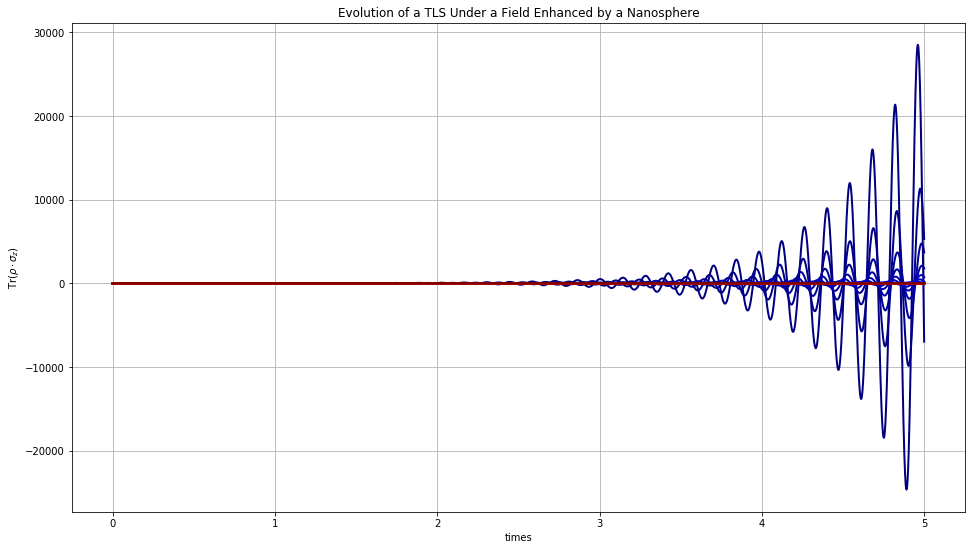

True

In [26]:
# no permanent dipole, spontaneous emission included

PDM_Evolution(x_points, y_points, z, m, ref_lam, a, E_0 = 10, dx = 1, dy = 0, dz = 0, lam_value = 0.54, 
              spontaneous_emission = True, times = np.linspace(0, 5, 100001), cmap = True)

[1.67805907-1.94838195j]


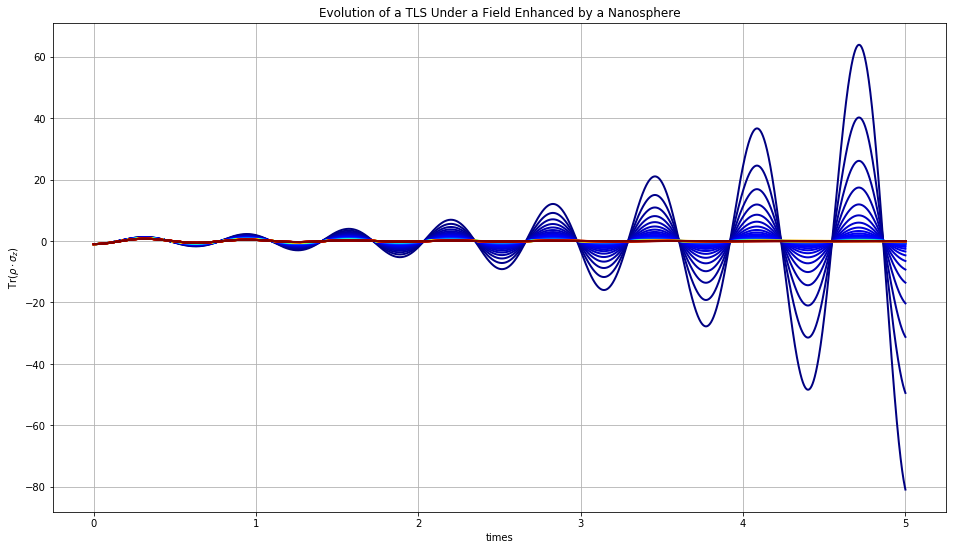

True

In [27]:
# Dipoles oriented along z-axis (parallel to smallest field component) + spontaneous emission

PDM_Evolution(x_points, y_points, z, m, ref_lam, a, E_0 = 10, dx = 0, dy = 0, dz = 1, lam_value = 0.38, 
              spontaneous_emission = True, times = np.linspace(0, 5, 100001), cmap = True)

[0.37250206-2.45166429j]


/home/niya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt


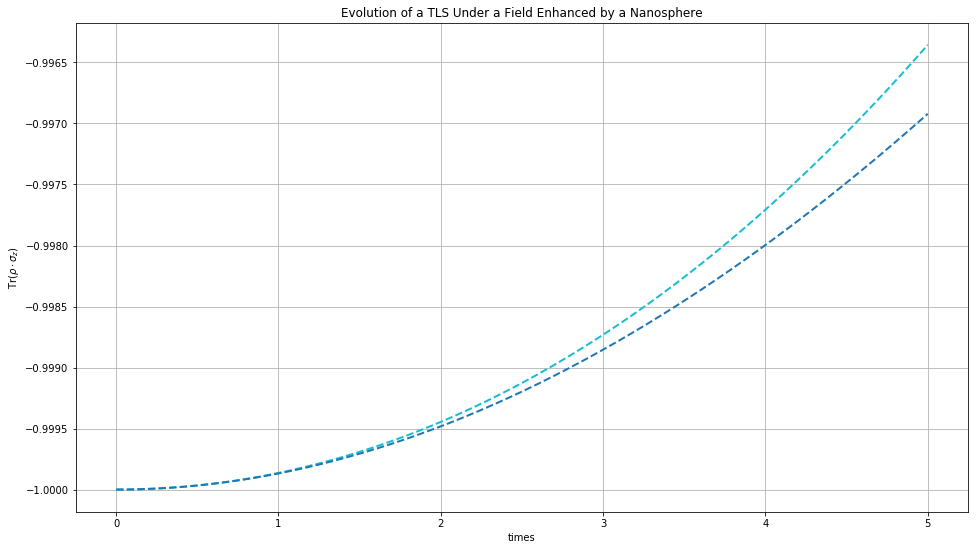

True

In [28]:
# Permanent Dipoles

PDM_Evolution(x_points, y_points, z, m, ref_lam, a, E_0 = 10, dx = 1, dy = 0, dz = 0, dperm = 0.5, 
              lam_value = 0.54, spontaneous_emission = True, times = np.linspace(0, 5, 100001))